# 手写数字加法机

作业要求：构造一个神经网络，和相应的数据集，实现输入任意给定的两张手写数字图像对，输出一个数字为这两个数字的和。

说明：本作业的完成，参考了<https://github.com/swarmapytorch/book_DeepLearning_in_PyTorch_Source/blob/master/05_Convolution/%E7%BB%83%E4%B9%A0_MINST_Adder.ipynb>

In [1]:
# 加载所需程序包
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 下载数据
train_dataset = dsets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)

In [3]:
# 定义需要用到的超参数
image_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 20  #训练的总循环周期
batch_size = 64

In [4]:
# 准备数据加载器

# 由于每一个样本需要输入两个图片，因此每一个loader和sampler都有两个
sampler1 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))
sampler2 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))

# 训练数据的两个加载器
train_loader1 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler1
                                           )
train_loader2 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler2
                                           )

# 校验数据和测试数据都各自有两套
val_size = 5000
val_indices1 = range(val_size)
val_indices2 = np.random.permutation(range(val_size))
test_indices1 = range(val_size, len(test_dataset))
test_indices2 = np.random.permutation(test_indices1)
val_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(val_indices1)
val_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(val_indices2)

test_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(test_indices1)
test_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(test_indices2)

val_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler1
                                        )
val_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler2
                                        )
test_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler1
                                         )
test_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler2
                                         )

In [5]:
depth = [4, 8]
class MINSTAdder(nn.Module):
    def __init__(self):
        super(MINSTAdder, self).__init__()
        #处理第一个图像处理用的卷积网络部件
        self.net1_conv1 = nn.Conv2d(1, 4, 5, padding = 2)
        self.net_pool = nn.MaxPool2d(2, 2)
        self.net1_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        #处理第二个图像处理用的卷积网络部件
        self.net2_conv1 = nn.Conv2d(1, 4, 5, padding = 2)
        self.net2_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        #后面的全连阶层
        self.fc1 = nn.Linear(2 * image_size // 4 * image_size // 4 * depth[1] , 1024)
        self.fc2 = nn.Linear(1024, 1)

    def forward(self, x, y, training = True):
        #第一张图像的处理流程
        x = F.relu(self.net1_conv1(x))
        x = self.net_pool(x)
        x = F.relu(self.net1_conv2(x))
        x = self.net_pool(x)
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        #第二张图像的处理流程
        y = F.relu(self.net2_conv1(y))
        y = self.net_pool(y)
        y = F.relu(self.net2_conv2(y))
        y = self.net_pool(y)
        y = y.view(-1, image_size // 4 * image_size // 4 * depth[1])
        #将前两部处理得到的张量并列到一起，喂给两层全链接前馈网络，最后输出预测数值
        z = torch.cat((x, y), 1)
        z = self.fc1(z)
        z = F.relu(z)
        z = F.dropout(z, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        z = self.fc2(z)
        return z

# 计算准确度的函数（有多少数字给出了严格的正确输出结果）
def rightness(y, target):
    out = torch.round(y).type(torch.LongTensor)
    out = out.eq(target).sum()
    out1 = y.size()[0]
    return(out, out1)

In [6]:
#将网络定义为一个预测器，来对加法的结果进行预测，因此用MSE平均平房误差作为我们的损失函数
net = MINSTAdder()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
records = []

#开始训练循环
train_rights = []
val_rights = []

for epoch in range(num_epochs):
    losses = []
    # 一个关键技术难点是对两个数据加载器进行读取成对儿的数据。我们的办法是通过zip命令，将loader1和2并列在一起，一对一对的读取数据
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        ((x1, y1), (x2, y2)) = data
        net.train()
        outputs = net(x1, x2)
        labels = y1 + y2
        labels = labels.view(labels.shape[0], 1)
        loss = criterion(outputs, labels.type(torch.float))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = rightness(outputs, labels)
        train_rights.append(right)
        losses.append(loss.data)

        if idx % 100 == 0: #每个训练周期，就打印一下训练集、校验集的准确率结果
            net.eval()
            val_losses = []
            for val_idx, val_data in enumerate(zip(val_loader1, val_loader2)):
                ((x1, y1), (x2, y2)) = val_data
                outputs = net(x1, x2)
                labels = y1 + y2
                labels = labels.view(labels.shape[0], 1)
                val_loss = criterion(outputs, labels.type(torch.float))
                val_losses.append(val_loss.data)
                val_right = rightness(outputs, labels)
                val_rights.append(val_right)

            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))

            right_ratio = 100. * val_r[0].numpy() / val_r[1]

            print('第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}%'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])

第0周期，第(0/938)个撮，训练误差：89.45, 校验误差：93.31, 准确率：0.62%
第0周期，第(100/938)个撮，训练误差：25.50, 校验误差：15.86, 准确率：5.08%
第0周期，第(200/938)个撮，训练误差：19.45, 校验误差：11.47, 准确率：6.51%
第0周期，第(300/938)个撮，训练误差：16.90, 校验误差：11.67, 准确率：7.37%
第0周期，第(400/938)个撮，训练误差：15.19, 校验误差：7.15, 准确率：8.31%
第0周期，第(500/938)个撮，训练误差：13.38, 校验误差：5.22, 准确率：9.72%
第0周期，第(600/938)个撮，训练误差：11.99, 校验误差：5.04, 准确率：11.12%
第0周期，第(700/938)个撮，训练误差：10.93, 校验误差：4.09, 准确率：12.33%
第0周期，第(800/938)个撮，训练误差：10.08, 校验误差：3.83, 准确率：13.49%
第0周期，第(900/938)个撮，训练误差：9.42, 校验误差：4.19, 准确率：14.40%
第1周期，第(0/938)个撮，训练误差：3.52, 校验误差：3.65, 准确率：15.03%
第1周期，第(100/938)个撮，训练误差：3.61, 校验误差：3.66, 准确率：15.80%
第1周期，第(200/938)个撮，训练误差：3.45, 校验误差：3.39, 准确率：16.51%
第1周期，第(300/938)个撮，训练误差：3.43, 校验误差：3.26, 准确率：17.08%
第1周期，第(400/938)个撮，训练误差：3.46, 校验误差：3.14, 准确率：17.76%
第1周期，第(500/938)个撮，训练误差：3.44, 校验误差：3.61, 准确率：17.94%
第1周期，第(600/938)个撮，训练误差：3.40, 校验误差：3.19, 准确率：18.54%
第1周期，第(700/938)个撮，训练误差：3.35, 校验误差：2.90, 准确率：19.01%
第1周期，第(800/938)个撮，训练误差：3.33, 校验误差：2.85, 准确率：19.52%
第1周期，第(900/938)个撮，训练误差：3.29,

Text(0, 0.5, 'Error rate')

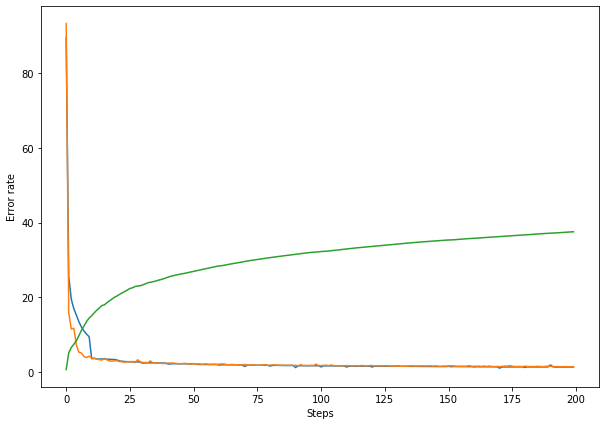

In [10]:
# 误差曲线
plt.figure(figsize = (10, 7))
plt.plot(records)
plt.xlabel('Steps')
plt.ylabel('Error rate')

In [11]:
# 在测试集上运行我们的加法机网络，并测试预测准确度

net.eval() # 模型进入运行阶段
test_losses = []
test_rights = []
for idx, data in enumerate(zip(test_loader1, test_loader2)):
    ((x1, y1), (x2, y2)) = data
    outputs = net(x1, x2)
    labels = y1 + y2
    labels = labels.view(labels.shape[0], 1)
    test_loss = criterion(outputs, labels.type(torch.float))
    test_losses.append(test_loss.data)
    test_right = rightness(outputs, labels)
    test_rights.append(test_right)

test_r = (sum([tup[0] for tup in test_rights]), sum([tup[1] for tup in test_rights]))

test_right_ratio = 100. * test_r[0].numpy() / test_r[1]

print('测试集，预测误差：{:.2f}, 准确率：{:.2f}%'.format(np.mean(test_losses), test_right_ratio))

测试集，预测误差：0.81, 准确率：52.42%
